# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : une partie qui vise à télécharger les bases de données utiles, une partie qui vise à étudier ses bases de données et à les analyser, et une partie qui vise à modéliser le problème pour tenter d'y apporter une réponse satisfiasante.

In [2]:
# !pip install cartopy
# !pip install geopy

In [3]:
import os
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import glob

from scipy.spatial import distance

In [4]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Debug

In [5]:
# Initialiser le géocodeur
geolocator = Nominatim(user_agent="geoapi")

# Fonction pour récupérer les coordonnées
def get_coordinates(adresse):
    
    try:
        location = geolocator.geocode(adresse)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except Exception as e:
        print(f"Erreur pour l'adresse {address}: {e}")
        return pd.Series([None, None])

NameError: name 'Nominatim' is not defined

In [ ]:
from geopy.geocoders import Nominatim

# Initialiser le géocodeur
geolocator = Nominatim(user_agent="myGeocoder")

# Géocodage
adresse = "12bis Rue de Paris 78560 Le Port-Marly"
location = geolocator.geocode(adresse)
# print(f"Latitude : {location.latitude}, Longitude : {location.longitude}")
location.latitude, location.longitude

In [ ]:
from geopy.geocoders import Nominatim

# Initialiser le géocodeur
geolocator = Nominatim(user_agent="myGeocoder")

def obtenir_coordonnees(

In [ ]:
adresses_clubs_aviron[['LAT', 'LON']] = adresses_clubs_aviron['adresse'].apply(get_coordinates)
adresses_clubs_aviron

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [6]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    station_au_hasard,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    create_nearest_stations_dataframe
)

---

Téléchargement des bases de données météo horaire, puis concaténation et nettoyage

In [7]:
# load_and_save_all_department_data(
#    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
#    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
# )

In [8]:
meteo_horaire_departement = load_data_from_disk(
    data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)
meteo_horaire_departement

Loading and concatenating data from disk:  38%|███▊      | 3/8 [00:00<00:00, 10.40it/s]

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00, 10.40it/s]


,DEPARTMENT_ID,NUM_POSTE,NOM_USUEL,LAT,LON,AAAAMMJJHH,RR1,T
0,77,77054001,LA BROSSE-MX,48.351667,3.023333,2023010100,0.0,14.2
1,77,77054001,LA BROSSE-MX,48.351667,3.023333,2023010101,0.0,13.7
2,77,77054001,LA BROSSE-MX,48.351667,3.023333,2023010102,0.0,13.5
3,77,77054001,LA BROSSE-MX,48.351667,3.023333,2023010103,0.0,13.3
4,77,77054001,LA BROSSE-MX,48.351667,3.023333,2023010104,0.0,12.8
...,...,...,...,...,...,...,...,...
138267,27,27422001,MUIDS,49.224167,1.280500,2024122023,1.0,8.0
138268,27,27422001,MUIDS,49.224167,1.280500,2024122100,0.2,8.3
138269,27,27422001,MUIDS,49.224167,1.280500,2024122101,0.0,8.5
138270,27,27422001,MUIDS,49.224167,1.280500,2024122102,0.0,8.5


In [ ]:
meteo_horaire_departement = cleaning_and_organizing(
                                df=meteo_horaire_departement,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )

Le dataframe meteo_horaire_departement contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

---

Création du dataset clubs d'aviron et récupération de leurs coordonnées GPS

In [9]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [10]:
# On applique la fonction get_coordinates à chaque adresse
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---

Création du dataset stations hydrométriques

In [11]:
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] #Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1)

---

Importation de la base de données fluviales

In [ ]:
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )

---

Création des bases de données avec les stations météo et hydro les plus proches des clubs d'aviron donnés

In [ ]:
stations_meteo = create_nearest_stations_dataframe(clubs_aviron, meteo_horaire_departement, filter_keyword=None)
stations_meteo

,NUM_POSTE,NOM_USUEL,LAT,LON
189831,76473001,NOTRE-DAME DE BLIQUETUIT,49.494000,0.770667
224399,76540009,ROUEN - JARDIN,49.422667,1.077333
0,76116001,ROUEN-BOOS,49.389500,1.178333
0,27016001,LES ANDELYS,49.244667,1.412833
17284,78354001,MAGNANVILLE,48.963667,1.674167
51852,78481001,LE PECQ,48.887833,2.115833
0,92073001,SURESNES,48.870667,2.234667
0,91027002,ORLY,48.718000,2.397000
17284,91103001,BRETIGNY_SAPC,48.600500,2.326000
138138,77306001,MELUN,48.610333,2.679500


In [ ]:
stations_hydro = create_nearest_stations_dataframe(clubs_aviron, liste_stations_hydro, 'Seine')

Stations_hydro et stations_meteo ne renvoient pas chacune des stations associée a chaque club d'aviron (non conservation des doublons de stations hydrométriques/meteo alors que l'on en a besoin pour ensuite). Proposition de changement :  ( a intégrer dans la partie fonctions si validé - mais en tout cas il faut absolument garder les doublons) - double interrogation sur comment fair eun joli tableau avec des lignes grisées et les colonnes en gras

In [87]:
# Fonction pour trouver la station la plus proche d'un club d'aviron donné
def find_nearest_station_ter(lat, lon, stations):
    # Filtrer les stations dont le libellé contient le mot "Seine"
    coords_station = stations[['LAT', 'LON']].values
    coords_point = [lat, lon]
    
    # Calcul des distances
    distances = distance.cdist([coords_point], coords_station, metric='euclidean')
    
    # Trouver l'index de la station la plus proche
    nearest_idx = distances.argmin()
    
    # Retourner le 'cdentite' et 'lbstationhydro' de la station la plus proche
    return stations.iloc[nearest_idx]['NUM_POSTE'], stations.iloc[nearest_idx]['NOM_USUEL']

# Ajout des colonnes d'identification de la station au DataFrame des adresses des clubs
def add_station_info_to_clubs(df_adresses_clubs, stations):
    # Appliquer la fonction à chaque ligne du DataFrame des adresses des clubs
    def get_station_info(row):
        return pd.Series(find_nearest_station_ter(row['LAT'], row['LON'], stations))
    
    # Appliquer la fonction à chaque ligne
    df_adresses_clubs[['NUM_POSTE', 'NOM_USUEL']] = df_adresses_clubs.apply(get_station_info, axis=1)
    return df_adresses_clubs

# Appliquer la fonction et ajouter les colonnes
stations_meteo_clubs= add_station_info_to_clubs(clubs_aviron, meteo_horaire_departement)

# Vérification que ca a bien fonctionné
stations_meteo_clubs


,Club,Adresse,LAT,LON,NUM_POSTE,NOM_USUEL
0,Aviron Caudebec Vallée de Seine,9 route de Villequier 76490 Rives-en-Seine,49.523301,0.711545,76473001,NOTRE-DAME DE BLIQUETUIT
1,Cercle nautique de Canteleu-Croisset,46 Quai Gustave Flaubert 76380 Canteleu,49.432313,1.027671,76540009,ROUEN - JARDIN
2,Club Nautique Et Athletique De Rouen,20 Rue de l'Industrie 76100 Rouen,49.435429,1.097776,76540009,ROUEN - JARDIN
3,Club nautique de Belbeuf,8 Rte de Paris 76240 Belbeuf,49.370154,1.127481,76116001,ROUEN-BOOS
4,Aviron Club Andelys-Tosny,Chemin de la Haguette 27700 Les Trois Lacs,49.229422,1.387091,27016001,LES ANDELYS
5,Emulation Nautique de Vernon,Impasse de la Chaussée 27200 Vernon,49.097958,1.488658,27016001,LES ANDELYS
6,Association sportive Mantaise,"Boulevard Sully, 78200 Mantes-la-Jolie",49.005356,1.687551,78354001,MAGNANVILLE
7,Aviron Meulan-les-Mureaux Hardricourt,15 Rue de Lorraine 78200 Mantes-la-Jolie,48.987514,1.713665,78354001,MAGNANVILLE
8,Aviron Club de Villennes-Poissy,Chemin des Pêcheurs 78670 Villennes-sur-Seine,48.931290,2.007438,78481001,LE PECQ
9,Rowing Club de Port-Marly,12 Rue de Paris 78560 Le Port-Marly,48.880091,2.111393,78481001,LE PECQ


In [81]:
# Fonction pour trouver la station la plus proche d'un club d'aviron donné
def find_nearest_station_bis(lat, lon, stations):
    # Filtrer les stations dont le libellé contient le mot "Seine"
    stations = stations[stations['NOM_USUEL'].str.contains('Seine', case=False, na=False)]
    coords_station = stations[['LAT', 'LON']].values
    coords_point = [lat, lon]
    
    # Calcul des distances
    distances = distance.cdist([coords_point], coords_station, metric='euclidean')
    
    # Trouver l'index de la station la plus proche
    nearest_idx = distances.argmin()
    
    # Retourner le 'cdentite' et 'lbstationhydro' de la station la plus proche
    return stations.iloc[nearest_idx]['NUM_POSTE'], stations.iloc[nearest_idx]['NOM_USUEL']

# Ajout des colonnes d'identification de la station au DataFrame des adresses des clubs
def add_station_info_to_clubs(df_adresses_clubs, stations):
    # Appliquer la fonction à chaque ligne du DataFrame des adresses des clubs
    def get_station_info(row):
        return pd.Series(find_nearest_station_bis(row['LAT'], row['LON'], stations))
    
    # Appliquer la fonction à chaque ligne
    df_adresses_clubs[['NUM_POSTE', 'NOM_USUEL']] = df_adresses_clubs.apply(get_station_info, axis=1)
    return df_adresses_clubs

# Appliquer la fonction et ajouter les colonnes
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro)

# Vérification que ca a bien fonctionné
stations_hydro_clubs


,Club,Adresse,LAT,LON,NUM_POSTE,NOM_USUEL
0,Aviron Caudebec Vallée de Seine,9 route de Villequier 76490 Rives-en-Seine,49.523301,0.711545,H512011001,La Seine à Caudebec-en-Caux
1,Cercle nautique de Canteleu-Croisset,46 Quai Gustave Flaubert 76380 Canteleu,49.432313,1.027671,H503011001,La Seine à Rouen
2,Club Nautique Et Athletique De Rouen,20 Rue de l'Industrie 76100 Rouen,49.435429,1.097776,H503011001,La Seine à Rouen
3,Club nautique de Belbeuf,8 Rte de Paris 76240 Belbeuf,49.370154,1.127481,H501012001,La Seine à Oissel
4,Aviron Club Andelys-Tosny,Chemin de la Haguette 27700 Les Trois Lacs,49.229422,1.387091,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
5,Emulation Nautique de Vernon,Impasse de la Chaussée 27200 Vernon,49.097958,1.488658,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
6,Association sportive Mantaise,"Boulevard Sully, 78200 Mantes-la-Jolie",49.005356,1.687551,H308000101,La Seine à Limay [Mantes]
7,Aviron Meulan-les-Mureaux Hardricourt,15 Rue de Lorraine 78200 Mantes-la-Jolie,48.987514,1.713665,H308000101,La Seine à Limay [Mantes]
8,Aviron Club de Villennes-Poissy,Chemin des Pêcheurs 78670 Villennes-sur-Seine,48.931290,2.007438,H300000201,La Seine à Poissy
9,Rowing Club de Port-Marly,12 Rue de Paris 78560 Le Port-Marly,48.880091,2.111393,F712000102,La Seine à Chatou - Barrage (aval)


In [17]:
liste_stations_a_récupérer = []
for element in stations_hydro_clubs['NUM_POSTE']:
    if element not in liste_stations_a_récupérer :
        liste_stations_a_récupérer.append(element)

# Voila les stations dont on doit télécharger l'historique des données hydro à la main
print("Les stations dont il faut récupérer les données dans les archives hydrométriques sont : " + ", ".join(liste_stations_a_récupérer))

Les stations dont il faut récupérer les données dans les archives hydrométriques sont : H512011001, H503011001, H501012001, H320000104, H308000101, H300000201, F712000102, F704000102, F704000101, F490000104, F449000601, F447000101, F400000301, H170001001, H080001101


In [73]:
#Cleaning des datasets et insertion dans un dictionnaire pour y avoir accès à tous en même temps

# Chemin où se trouvent les fichiers de débit des stations hydrométriques
chemin_fichiers = "/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/*.csv"

# Chargement dans un dictionnaire
fichiers = glob.glob(chemin_fichiers)
dictionnaire_df_stations_hydro = {}

for fichier in fichiers :
    # Extraire le NUM_POSTE du nom du fichier
    NUM_POSTE = fichier.split("/")[-1].split(".")[0]
    df = pd.read_csv(fichier)

    #Création d'une colonne date time pour uniformiser avec les donénes météo ensuite)
    df['Datetime'] = pd.to_datetime(df['Date (TU)'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S.%f')
    # Supprimer les colonnes inutiles
    df = df.drop(columns=["Date (TU)", "Statut", "Qualification", "Méthode", "Continuité"], errors="ignore")
    df = df[['Datetime', 'Valeur (en m³/s)']]

    # Convertir la colonne "Valeur (en m³/s)" en entier
    df["Valeur (en m³/s)"] = pd.to_numeric(df["Valeur (en m³/s)"].astype(str).str.replace(",", "").str.replace('"', ""), errors="coerce").fillna(0).astype(int)
    dictionnaire_df_stations_hydro[NUM_POSTE] = df

# Vérification des clés  (à savoir les NUM_POSTE)
print("Numéros de postes hydrométriques disponibles :", dictionnaire_df_stations_hydro.keys())


for nom, df in dictionnaire_df_stations_hydro.items():
    print(f"Les 5 premières lignes de {nom}:")
    print(df.head())  # Affiche les 5 premières lignes
    print()  # Ligne vide pour la lisibilité


#On a finalement un dictionnaire avec tous les dataframes des bases hydro à l'interieur, avec uniquement le débit heure par heure à chaque station.

Numéros de postes hydrométriques disponibles : dict_keys(['F490000104', 'H320000104', 'H512011001', 'F447000101', 'H503011001', 'H080001101', 'F704000102', 'H300000201', 'F704000101', 'F449000601', 'H308000101', 'F400000301', 'H170001001', 'F712000102', 'H501012001'])
Les 5 premières lignes de F490000104:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               237
1 2023-01-01 01:00:00               238
2 2023-01-01 02:00:00               241
3 2023-01-01 03:00:00               233
4 2023-01-01 04:00:00               235

Les 5 premières lignes de H320000104:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               503
1 2023-01-01 01:00:00               508
2 2023-01-01 02:00:00               515
3 2023-01-01 03:00:00               521
4 2023-01-01 04:00:00               522

Les 5 premières lignes de H512011001:
             Datetime  Valeur (en m³/s)
0 2023-01-01 00:00:00               748
1 2023-01-01 01:00:00               748
2 2023-01-01 02

Création du dictionnaire contenant les df des données météo : 

In [72]:
# 1. Charger tous les fichiers CSV d'un dossier spécifique
chemin_files = '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/*.csv'
files = glob.glob(chemin_files)

# 2. Créer un dictionnaire pour stocker les DataFrames par station
dictionnaire_df_stations_meteo = {}

# 3. Charger et traiter les fichiers
for file in files:
    print(f"Traitement du fichier : {file}")
    
    # Lire chaque fichier CSV
    df = pd.read_csv(file)
        
    # Convertir la colonne 'AAAAMMJJHH' en datetime
    df['Datetime'] = pd.to_datetime(df['AAAAMMJJHH'], format='%Y%m%d%H')
    
    # Sélectionner les colonnes nécessaires
    df_filtered = df[['Datetime', 'NUM_POSTE', 'T', 'RR1']]
    
    # Définir 'Datetime' comme index
    df_filtered.set_index('Datetime', inplace=True)
    
    # Parcourir chaque station (NUM_POSTE)
    for station_id in df_filtered['NUM_POSTE'].unique():
        # Filtrer les données pour cette station
        df_station = df_filtered[df_filtered['NUM_POSTE'] == station_id].drop(columns='NUM_POSTE')
        
        # Ajouter ou mettre à jour le DataFrame de la station dans le dictionnaire
        if station_id not in dictionnaire_df_stations_meteo:
            dictionnaire_df_stations_meteo[station_id] = df_station
        else:
            dictionnaire_df_stations_meteo[station_id] = pd.concat([dictionnaire_df_stations_meteo[station_id], df_station])
        
# Vérification du résultat
for station_id, station_df in dictionnaire_df_stations_meteo.items():
    print(f"DataFrame pour la station {station_id}:")
    print(station_df.head())  # Affiche les 5 premières lignes de chaque station
    print("\n")

print("NUM_POSTE disponibles dans le dictionnaire :", dictionnaire_df_stations_meteo.keys())


Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/77.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/95.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/78.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/10.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/76.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/91.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/92.csv
Traitement du fichier : /home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/27.csv
DataFrame pour la station 77054001:
                        T  RR1
Datetime                      
2023-01-01 00:00:00  14.2  0.0
2023-01

# **Data analysis**

In [ ]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

ModuleNotFoundError: No module named 'cartopy'

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

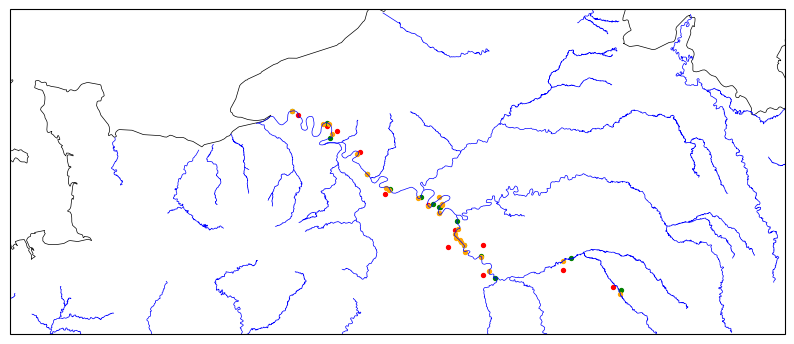

In [ ]:
carte_figures(rivers, stations_meteo, stations_hydro, clubs_aviron)

---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [ ]:
# On choisit une station au hasard pour les graphiques
random_station = stations_meteo["NOM_USUEL"].sample(n=1, random_state=0).iloc[0]
meteo_random_station = station_au_hasard(random_station, meteo_horaire_departement)

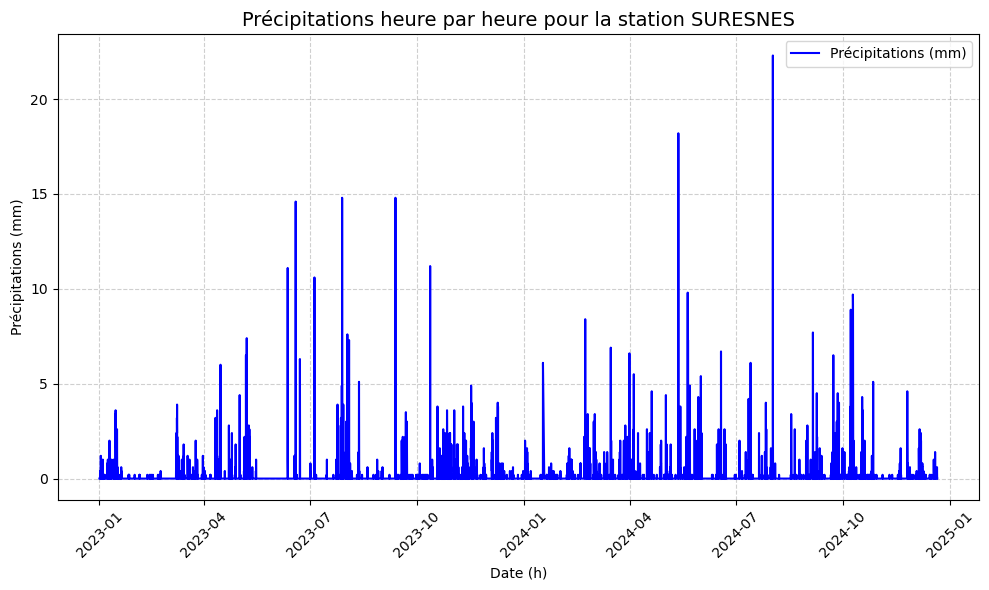

In [ ]:
trace_graphique(
    x=meteo_random_station["AAAAMMJJHH"],
    y=meteo_random_station["RR1"],
    titre=f"Précipitations heure par heure pour la station {random_station}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire** est utile pour analyser la variabilité des précipitations à court terme. Toutefois, elle rend difficile la lecture des **tendances globales** à cause de l'apparente "saturation" de l'information.  

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels.

2. b. <u>Par semaine</u>

In [ ]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_random_station['hebdo'] = meteo_random_station['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

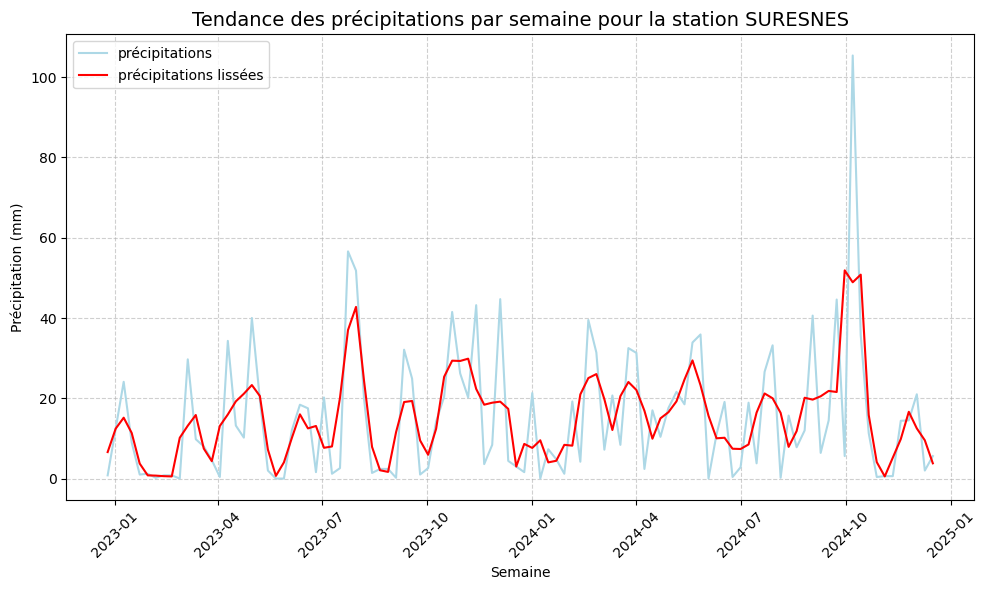

In [ ]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour la station {random_station}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

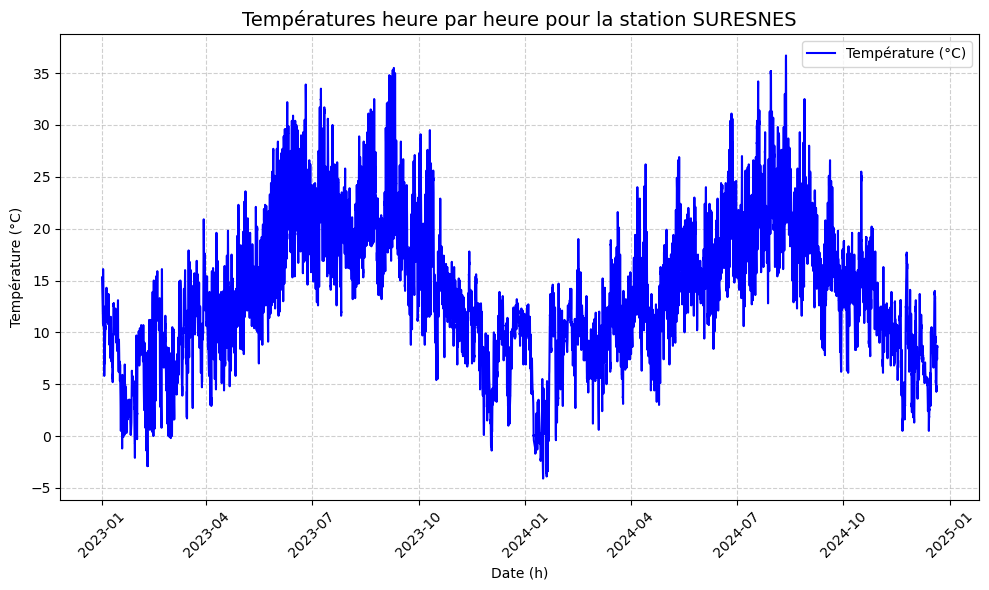

In [ ]:
trace_graphique(
    x=meteo_random_station["AAAAMMJJHH"],
    y=meteo_random_station["T"],
    titre=f"Températures heure par heure pour la station {random_station}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

3. b. <u>Par semaine</u>

In [ ]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

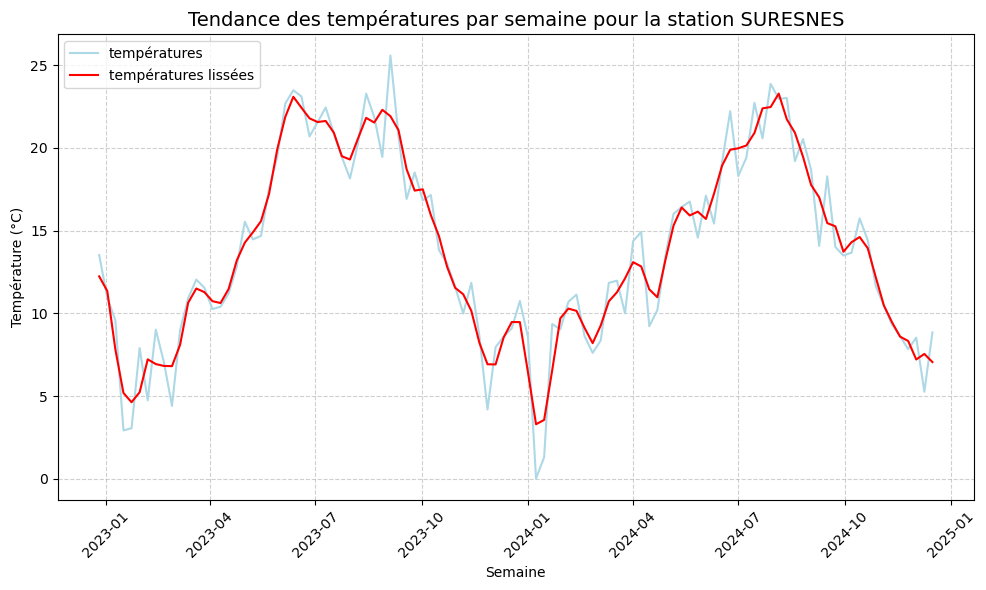

In [ ]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour la station {random_station}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

# **Data modeling**

Formalisation des requêtes de recherche dans les dictionnaires précédemment crées : 
Il suffit d'entrer le nom du club sur lequel on souhaite obtenir l'ensemble des données

In [80]:
nom_club = 'Emulation Nautique de Vernon'


def get_station_data_by_club(club_name, stations_hydro_clubs, dictionnaire_df_stations_hydro):
    """
    Récupère les données de débit de la station hydrométrique associée à un club d'aviron.

    Args:
        club_name (str): Le nom du club d'aviron.
        df_adresses_clubs (DataFrame): DataFrame contenant les clubs et leurs stations associées.
        dictionnaire_df_stations_hydro (dict): Dictionnaire contenant les DataFrames des données de débit.

    Returns:
        DataFrame or None: Les données de débit de la station associée au club ou None si non trouvé.
    """
 # Trouver l'identifiant de la station associée au club
    print(stations_hydro_clubs)
    station_id = stations_hydro_clubs.loc[stations_hydro_clubs['Club'] == club_name, 'NUM_POSTE'].values
    print(station_id)
    if len(station_id) == 0:
        print(f"Aucune station associée au club : {club_name}")
        return None

    station_id = station_id[0]  # Extraire l'identifiant unique
    print(station_id)
    print("Stations hydro  disponibles :", dictionnaire_df_stations_hydro.keys())

    # Récupérer les données de la station
    if station_id in dictionnaire_df_stations_hydro:
        return dictionnaire_df_stations_hydro[station_id]
    else:
        print(f"Aucune donnée de débit trouvée pour la station : {station_id}")
        return None

df_debit=get_station_data_by_club ( nom_club, stations_hydro_clubs, dictionnaire_df_stations_hydro)
print(df_debit)



def get_meteo_data_by_club(club_name, stations_meteo_clubs, dictionnaire_df_stations_meteo ):

 # Trouver l'identifiant de la station associée au club
    station_id2 = stations_meteo_clubs.loc[stations_meteo_clubs['Club'] == club_name, 'NUM_POSTE'].values

    station_id2 = station_id2[0]  # Extraire l'identifiant unique
    print(station_id2)
    print("Stations météorologiques disponibles :", dictionnaire_df_stations_meteo.keys())

    
    # Récupérer les données de la station
    if station_id2 in dictionnaire_df_stations_meteo:
        return dictionnaire_df_stations_meteo[station_id2]
    else:
        print(f"Aucune donnée météo trouvée pour la station : {station_id2}")
        return None


df_meteo=get_meteo_data_by_club( nom_club, stations_meteo_clubs, dictionnaire_df_stations_meteo)
print(df_meteo)


                                               Club  \
0                   Aviron Caudebec Vallée de Seine   
1              Cercle nautique de Canteleu-Croisset   
2              Club Nautique Et Athletique De Rouen   
3                          Club nautique de Belbeuf   
4                         Aviron Club Andelys-Tosny   
5                      Emulation Nautique de Vernon   
6                     Association sportive Mantaise   
7             Aviron Meulan-les-Mureaux Hardricourt   
8                   Aviron Club de Villennes-Poissy   
9                         Rowing Club de Port-Marly   
10          Club Olympique Multisports d'Argenteuil   
11               Société Nautique de la Basse-Seine   
12                        Cercle nautique de France   
13                            Val-de-Seine Nautique   
14                                      Boulogne 92   
15                  Club Nautique d'Ablon-sur-Seine   
16               Société Nautique de la Haute Seine   
17        

Et la fusion : 

In [34]:
# Fusionner les DataFrames sur la colonne datetime
df_combined = pd.merge(df_debit, df_meteo, on='Datetime', how='outer', suffixes=('_debit', '_meteo'))

# Trier les données par datetime et réinitialiser l'index
df_combined = df_combined.sort_values(by='Datetime').reset_index(drop=True)

df_combined
df_combined = df_combined.drop_duplicates(subset='Datetime').reset_index(drop=True)
# Afficher les premières lignes du DataFrame combiné
print(df_combined)

TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

Il faudra restreindre les datasets de meteo au 30 novembre 2024 (la ou je me suis arreté dans le téléchargement des df débit)

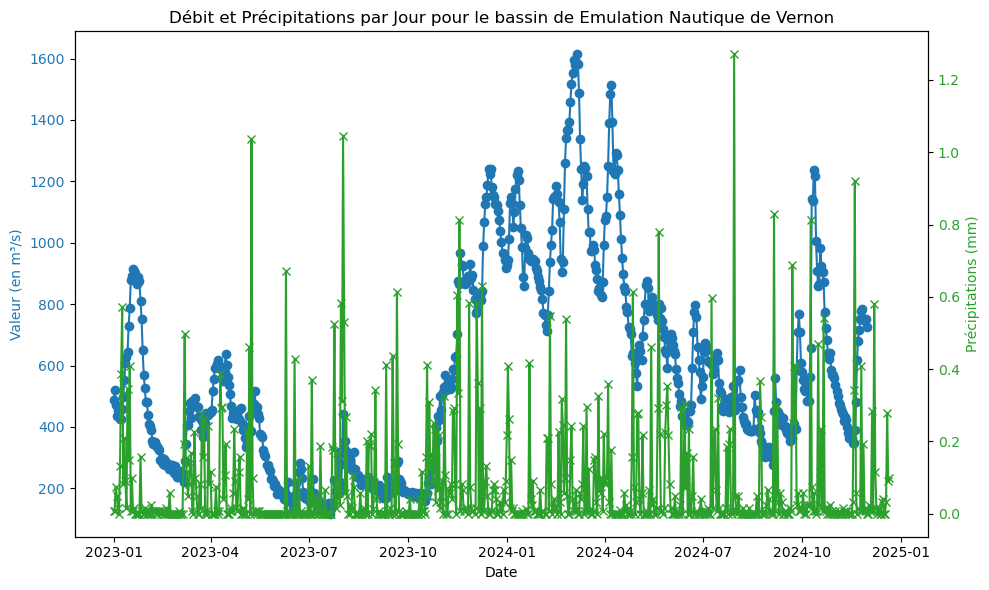

In [ ]:
# Lissage par jour (moyenne quotidienne)
df_daily = df_combined.groupby(df_combined['Datetime'].dt.date).agg({'Valeur (en m³/s)': 'mean', 'RR1': 'mean'}).reset_index()

# Créer le plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot des débits sur le premier axe
ax1.plot(df_daily['Datetime'], df_daily['Valeur (en m³/s)'], color='tab:blue', label='Débit', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Débit (en m³/s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ajouter un deuxième axe pour les précipitations
ax2 = ax1.twinx()
ax2.plot(df_daily['Datetime'], df_daily['RR1'], color='tab:green', label='Précipitations', linestyle='-', marker='x')
ax2.set_ylabel('Précipitations (mm)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')


# Titre et affichage
plt.title(f'Débit et Précipitations par Jour pour le bassin de {nom_club}')
fig.tight_layout()
plt.show()

In [1]:
# Initialisation d'une liste pour stocker les DataFrames combinés
dataframes_combined = []

# Parcourir chaque club d'aviron
for club in adresses_clubs['Club'].unique():
    print(f"Traitement pour le club : {club}")
    
    # Récupérer les informations du club
    club_row = adresses_clubs[adresses_clubs['Club'] == club]
    if club_row.empty:
        print(f"Aucune information trouvée pour le club : {club}")
        continue

    LAT, LON = club_row[['LAT', 'LON']].iloc[0]

    # Récupérer les informations des stations associées dans les DataFrames stations_hydro_club et stations_meteo_club
    hydro_row = stations_hydro_clubs[stations_hydro_clubs['Club'] == club]
    meteo_row = stations_meteo_clubs[stations_meteo_clubs['Club'] == club]
    
    if hydro_row.empty or meteo_row.empty:
        print(f"Aucune station trouvée pour le club : {club}")
        continue

    NUM_POSTE_HYDRO = hydro_row['NUM_POSTE'].iloc[0]
    NUM_POSTE_METEO = meteo_row['NUM_POSTE'].iloc[0]

    # Récupérer les données de débit et de météo
    df_debit = dictionnaire_df_stations_hydro.get(f"df_débit_{NUM_POSTE_HYDRO}")
    df_meteo = dictionnaire_df_stations_meteo.get(NUM_POSTE_METEO)
    
    if df_debit is None or df_meteo is None:
        print(f"Données insuffisantes pour le club : {club}")
        continue

    # Fusionner les données hydro et météo
    df_combined = pd.merge(df_debit, df_meteo, on='Datetime', how='outer', suffixes=('_debit', '_meteo'))

    # Ajouter des colonnes de métadonnées
    df_combined['Club'] = club
    df_combined['Station_Hydro'] =  NUM_POSTE_HYDRO
    df_combined['Station_Meteo'] =  NUM_POSTE_METEO
    df_combined['Latitude'] = LAT
    df_combined['Longitude'] = LON
    
    # Ajouter le DataFrame combiné à la liste
    dataframes_combined.append(df_combined)

# Concaténer tous les DataFrames dans un grand DataFrame
grand_dataframe = pd.concat(dataframes_combined, ignore_index=True)

# Nettoyage final : Trier par datetime et supprimer les doublons
grand_dataframe = grand_dataframe.sort_values(by='Datetime').drop_duplicates(subset=['Datetime', 'Club']).reset_index(drop=True)

# Affichage du DataFrame final
print(grand_dataframe.head())

NameError: name 'adresses_clubs' is not defined